In [1]:
import pandas as pd

import Constants as Const
import DataLoader

MATCHNIG_BUG_REPORT = 'Matching Bug Report'

df = DataLoader.load_resolved_sheet()

In [2]:
matches = df[df[MATCHNIG_BUG_REPORT]]
app_reviews = DataLoader.load_df_compressed(Const.APP_REVIEWS)

def find_review_date(x):
    review_id = x['user_feedback_id']
    return app_reviews[app_reviews['reviewId']==review_id]['at'].values[0]

matches['app_review_date'] = matches.apply(find_review_date, axis=1)
matches['app_review_date'] =  pd.to_datetime(matches['app_review_date'], utc=True)

firefox_issues = DataLoader.load_df_compressed(Const.FIREFOX_ISSUES_ANDROID)[['id', 'creation_time']].rename(columns={'creation_time': 'issue_date'})
ff_matches = matches[matches['App']=='Firefox'].merge(firefox_issues, how='left', left_on='issue_id', right_on='id')
ff_matches['issue_date'] = pd.to_datetime(ff_matches['issue_date'])

vlc_issues = DataLoader.load_df_compressed(Const.VLC_ISSUES)[['id', 'time']].rename(columns={'time': 'issue_date'})
vlc_matches = matches[matches['App']=='VLC'].merge(vlc_issues, how='left', left_on='issue_id', right_on='id')
vlc_matches['issue_date'] = pd.to_datetime(vlc_matches['issue_date'])

signal_issues = DataLoader.load_df_compressed(Const.SIGNAL_ISSUES)[['id', 'created_at']].rename(columns={'created_at': 'issue_date'})
signal_matches = matches[matches['App']=='Signal'].merge(signal_issues, how='left', left_on='issue_id', right_on='id')
signal_matches['issue_date'] = pd.to_datetime(signal_matches['issue_date'])

nextcloud_issues = DataLoader.load_df_compressed(Const.NEXTCLOUD_ISSUES)[['id', 'created_at']].rename(columns={'created_at': 'issue_date'})
nextcloud_matches = matches[matches['App']=='Nextcloud'].merge(nextcloud_issues, how='left', left_on='issue_id', right_on='id')
nextcloud_matches['issue_date'] = pd.to_datetime(nextcloud_matches['issue_date'])

matches = pd.concat([ff_matches, vlc_matches, signal_matches, nextcloud_matches], ignore_index=True)
matches['issue_date'] = pd.to_datetime(matches['issue_date'], utc=True)


In [3]:
report_after_review = matches['issue_date'] > matches['app_review_date']
report_after_review.value_counts()

False    135
True      33
dtype: int64

In [6]:
import seaborn as sns
pd.options.display.max_colwidth = 500
early_reports = matches[report_after_review][['App', 'user_feedback', 'issue_text', 'app_review_date', 'issue_date']]
early_reports['delta in days'] = (matches['issue_date']-matches['app_review_date']).dt.days
early_reports
# print(early_reports.loc[71]['user_feedback'])
# early_reports.loc[71]['issue_text']



count      33.000000
mean      508.757576
std       401.154430
min        29.000000
25%       196.000000
50%       370.000000
75%       936.000000
max      1233.000000
Name: delta in days, dtype: float64

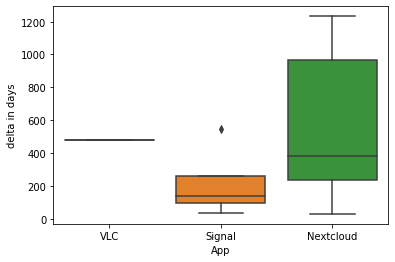

In [5]:
sns.boxplot(
    x=early_reports['App'],
    y=early_reports['delta in days']
            # palette = 'hls',
            # capsize = 0.05,             
            # saturation = 8,             
            # errcolor = 'gray', errwidth = 2,  
            # ci = 'sd'   
            )

early_reports['delta in days'].describe()